In [1]:
import pandas as pd
import numpy as np
#import graphlab as tc
import turicreate as tc
from tqdm.notebook import tqdm
import turicreate.aggregate as agg
from sklearn.model_selection import train_test_split
from numpy.random import default_rng

from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
import pickle
import matplotlib.pyplot as plt

In [2]:
mw = tc.load_sframe('../binarydata/funcs-encoded')
mw = mw.remove_column('fcount', inplace=True)

In [3]:
test_apns = np.load('../res/test-tc-1000.npy')

In [4]:
net_file = '../res/9003-tc-jaccard-votingnets.pickle'
with open(net_file, 'rb') as f:
    nets = pickle.load(f)

In [157]:
gamma = 0.6666666666666666
ref, mer = nets[gamma]

In [30]:
## recommender for all exclude test from similar items?

In [78]:
def tc_based_nn(net, apks, data):
    anch = list(net.keys())
    anch.extend(apks)
    allt = data.filter_by(values=anch, column_name='apk')

    m = len(anch)
    sim_recom = tc.item_similarity_recommender.create(
        allt, 
        user_id='function', 
        item_id='apk', 
        similarity_type='jaccard', 
        only_top_k=m, verbose=False)
    
    # smaller k could be an optimization here
    items =sim_recom.get_similar_items(apks, k=m)
    # recomendations excluding network anchors 
    fitems = items.filter_by(values=apks, column_name='similar', exclude=True)
    
    return fitems.groupby(key_column_names=['apk'], operations={'nn': tc.aggregate.ARGMAX('score', 'similar')})

In [81]:
nns = tc_based_nn(ref, list(test_apns), mw)

nns.head()

apk,nn
26561,3
16257,20486
12088,3
2464,9218
26001,3
19279,11
18741,18454
18939,2074
21368,3
11452,20486


In [82]:
# convert to votes

In [173]:
def s_conver_to_probs(v):
    return 1.0 - v[1]/(v[0]+v[1])

In [105]:
## full prediction

In [141]:
def eval_net(net, test_apns, data):
    nns = tc_based_nn(net, list(test_apns), data)
    return [s_conver_to_probs(net[row['nn']]) for row in nns.sort('apk')]


In [384]:
res = dict()
res_mer = dict()

#sorting to keep the results consistent (probs matching true values)
test_apns.sort()
true_values = [not labels.loc[a]['malware_label'] for a in test_apns]


for gamma, [ref, mer] in tqdm(nets.items()):
    res[gamma] = [eval_net(net=ref, test_apns=test_apns, data=mw), true_values]
    res_mer[gamma] = [eval_net(net=mer, test_apns=test_apns, data=mw), true_values]
    

  0%|          | 0/19 [00:00<?, ?it/s]

In [385]:
with open('../res/tc-new-res.pickle', 'wb+') as f:
    pickle.dump(res, f)

with open('../res/tc-new-mer.pickle', 'wb+') as f:
    pickle.dump(res_mer, f)

In [163]:
gammas = [0.0, 0.5, 0.6111111111111112, 0.7777777777777778, 0.8888888888888888]

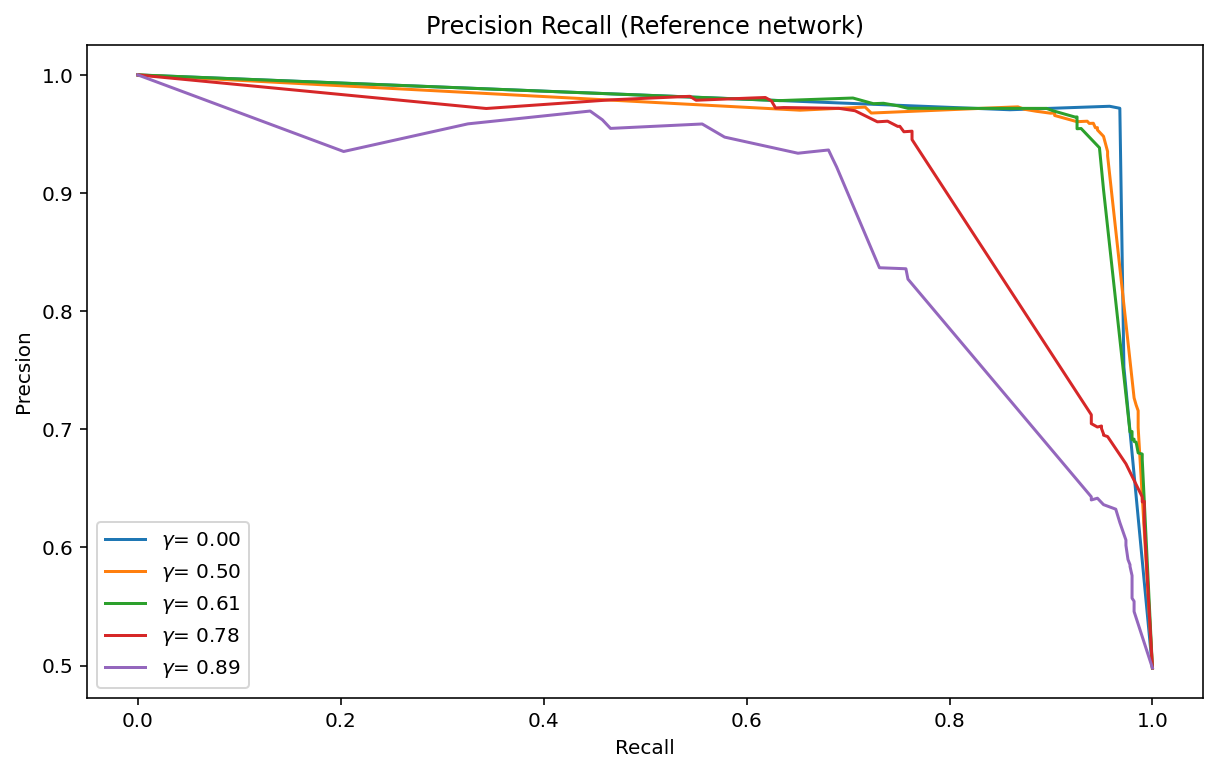

In [172]:
plt.figure(figsize=(10,6))
plt.title('Precision Recall (Reference network)')
plt.xlabel('Recall')
plt.ylabel('Precsion')
for gamma in gammas:
    probs, true_vals = res[gamma]
    [precisons, recalls, thresholds] = precision_recall_curve(true_vals, probs)
    plt.plot(recalls, precisons, label=f"$\gamma$= {gamma:.2f}")
plt.legend();

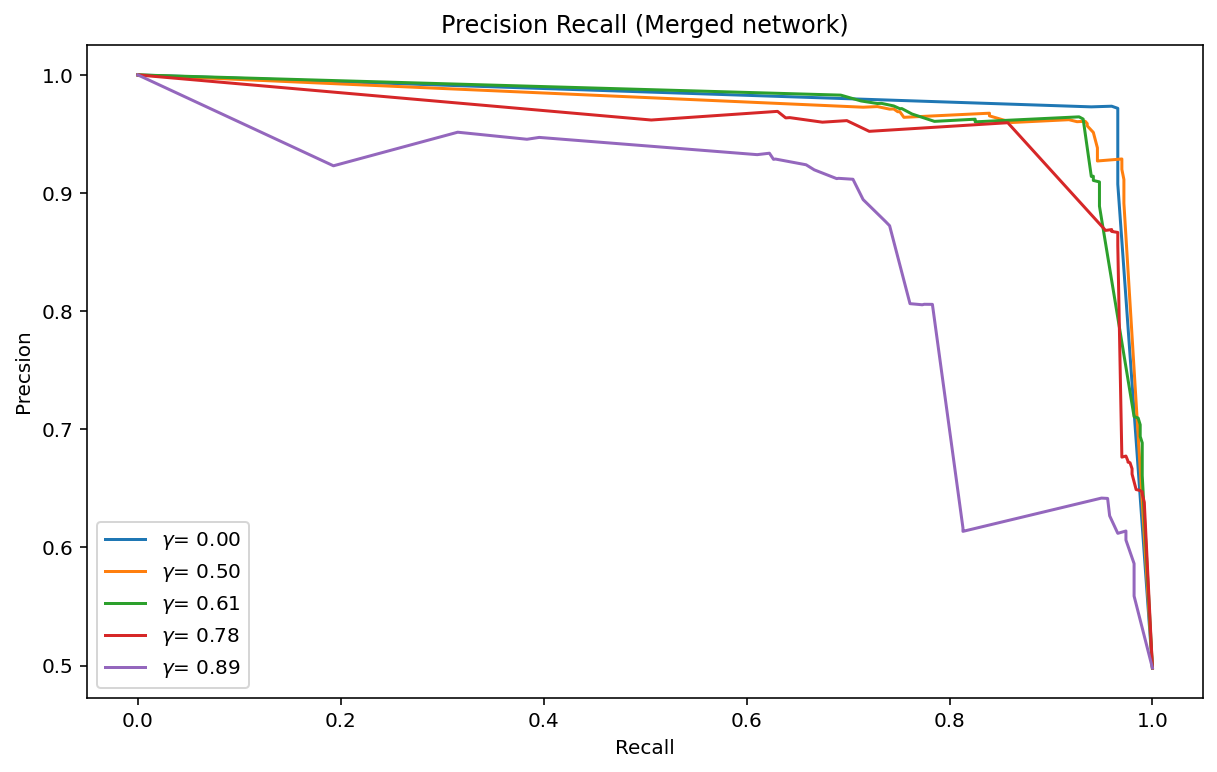

In [171]:
plt.figure(figsize=(10,6))
plt.title('Precision Recall (Merged network)')
plt.xlabel('Recall')
plt.ylabel('Precsion')
for gamma in gammas:
    probs, true_vals = res_mer[gamma]
    [precisons, recalls, thresholds] = precision_recall_curve(true_vals, probs)
    plt.plot(recalls, precisons, label=f"$\gamma$= {gamma:.2f}")
plt.legend();
# AuC

In [183]:
# compression
d_size = sum(map(sum, mer.values()))

compr = dict()
for gamma, [ref, mer] in nets.items():
    compr[gamma] = [len(ref)/d_size, len(mer) /d_size]

df = pd.DataFrame.from_dict(compr, orient='index', columns=['ref', 'mer'])

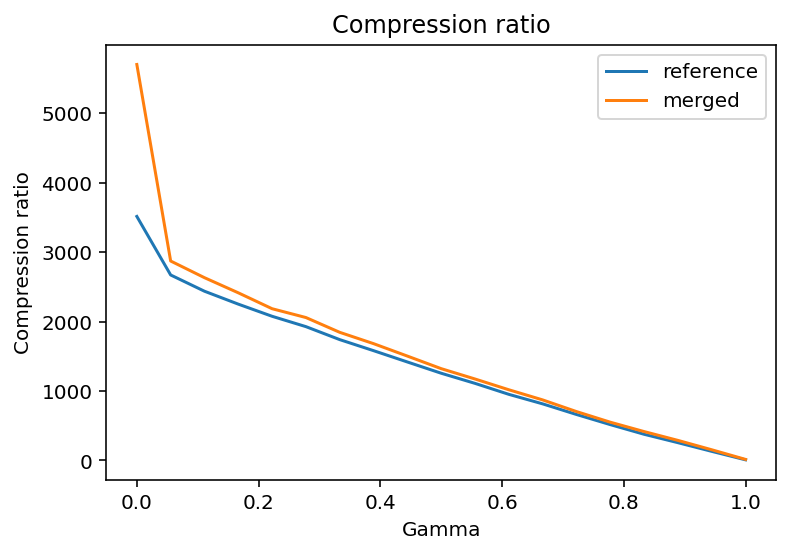

In [245]:
plt.title("Compression ratio ")
plt.plot(df.ref*d_size, label='reference')
plt.plot(df.mer*d_size, label='merged')
plt.xlabel('Gamma')
plt.ylabel('Compression ratio')
plt.legend();

In [430]:
from scipy.stats import linregress

In [439]:
comp_mer = {gamma: len(voting) for gamma, [merged, voting] in nets.items()}

In [442]:

res = linregress(list(comp_mer.keys())[1:], list(comp_mer.values())[1:])
print(res)


LinregressResult(slope=-2972.6377708978325, intercept=2884.836601307189, rvalue=-0.9972534373717314, pvalue=1.614141302623645e-19, stderr=55.19348288747532, intercept_stderr=33.19077036024268)


In [449]:
np.array(list(comp_mer.keys()))

array([0.        , 0.05555556, 0.11111111, 0.16666667, 0.22222222,
       0.27777778, 0.33333333, 0.38888889, 0.44444444, 0.5       ,
       0.55555556, 0.61111111, 0.66666667, 0.72222222, 0.77777778,
       0.83333333, 0.88888889, 0.94444444, 1.        ])

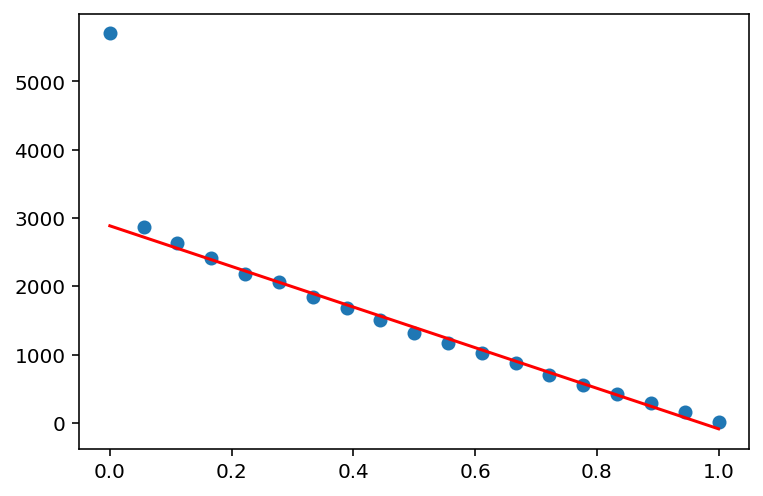

In [450]:
x = np.array(list(comp_mer.keys()))
y = list(comp_mer.values())

plt.plot(x, y, 'o')
plt.plot(x, res.intercept + res.slope*x, 'r', label='fitted line')


In [189]:
## not compressing to the end

In [5]:
ref, mer= nets[1.0]
print(len(ref), len(mer))

8 14


In [9]:
ref.keys(), mer.keys(), len(ref.keys())

(dict_keys([0, 23424, 22784, 22529, 4177, 11019, 26380, 1559]),
 dict_keys([0, 8200, 2049, 22529, 22784, 15873, 6788, 11365, 11019, 26350, 4177, 16891, 11318, 1559]),
 8)

## Verify the distances between anchors in the network

Here we use alternative distance calculation to check if distances are really $1.0$

In [58]:
m = pd.read_csv('../data/joined.csv', index_col='apn')
m['nf'] = m['nf'].apply(eval)

In [59]:
def jaccard(apid1: int, apid2: int, funcs) -> float:
    p1 = funcs[apid1]
    p2 = funcs[apid2]

    return 1 - len(p1 & p2)/len(p1|p2)


distance = lambda x,y: jaccard(x, y, m['nf'])

In [99]:
def check_net(net, distance):
    mismatched = []
    keys = list(net.keys())
    for i in tqdm(keys):
        for j in keys:
            if (i!=j) and ((d:=distance(i, j))!=1.0):
                print(i, j, d)
                mismatched.append((i,j))
    return mismatched

In [100]:
mi = check_net(ref, distance)
print(f"Number of mismatched anchors (ref network): {len(mi)}")

  0%|          | 0/8 [00:00<?, ?it/s]

Number of mismatched anchors (ref network): 0


In [101]:
mi = check_net(mer, distance)
print(f"Number of mismatched anchors (merged): {len(mi)}")

  0%|          | 0/14 [00:00<?, ?it/s]

0 8200 0.9836065573770492
0 2049 0.9836065573770492
0 6788 0.9895833333333334
0 11365 0.984375
0 26350 0.9859154929577465
8200 0 0.9836065573770492
8200 2049 0.0
8200 6788 0.9736842105263158
8200 11365 0.6
8200 26350 0.9230769230769231
8200 11318 0.5
2049 0 0.9836065573770492
2049 8200 0.0
2049 6788 0.9736842105263158
2049 11365 0.6
2049 26350 0.9230769230769231
2049 11318 0.5
6788 0 0.9895833333333334
6788 8200 0.9736842105263158
6788 2049 0.9736842105263158
6788 11365 0.975609756097561
6788 26350 0.9791666666666666
11365 0 0.984375
11365 8200 0.6
11365 2049 0.6
11365 6788 0.975609756097561
11365 26350 0.9375
11365 11318 0.8
26350 0 0.9859154929577465
26350 8200 0.9230769230769231
26350 2049 0.9230769230769231
26350 6788 0.9791666666666666
26350 11365 0.9375
11318 8200 0.5
11318 2049 0.5
11318 11365 0.8
Number of mismatched anchors (merged): 36


In [96]:
apks = mw['apk'].unique()
apks.shape

(10003,)

In [131]:
mw[(mw['apk']==8200)|(mw['apk']==11318)]

apk,function
8200,178583
8200,101925
11318,101925


In [133]:
## limited recommender (as in network calculation)
km = len(mer)
sim_recom = tc.item_similarity_recommender.create(
        mw, 
        user_id='function', 
        item_id='apk', 
        similarity_type='jaccard', 
        only_top_k=km, threshold=0.0, verbose=False)

items =sim_recom.get_similar_items(list(mer.keys()), k=km)
items

apk,similar,score,rank
0,3451,1.0,1
0,20974,0.9672130942344666,2
0,24359,0.9672130942344666,3
0,484,0.9672130942344666,4
0,23212,0.9672130942344666,5
0,1595,0.9672130942344666,6
0,585,0.9672130942344666,7
0,8597,0.9672130942344666,8
0,5863,0.9672130942344666,9
0,9343,0.9354838728904724,10


In [134]:
res = items[(items['apk']==8200)&(items['similar']==11318)]['score']
res.materialize()

res

dtype: float
Rows: 0
[]

In [135]:
## full recommender
km = apks.shape[0]
sim_recom_f = tc.item_similarity_recommender.create(
        mw, 
        user_id='function', 
        item_id='apk', 
        similarity_type='jaccard', 
        only_top_k=km, threshold=0.0, verbose=False)

items2 =sim_recom_f.get_similar_items(list(mer.keys()), k=km)
items2

apk,similar,score,rank
0,585,1.0,1
0,2848,1.0,2
0,9343,1.0,3
0,11127,0.9672130942344666,4
0,5863,0.9672130942344666,5
0,24359,0.9672130942344666,6
0,3451,0.9672130942344666,7
0,27488,0.9672130942344666,8
0,6003,0.9672130942344666,9
0,25340,0.9354838728904724,10


In [136]:
res = items2[(items2['apk']==8200)&(items2['similar']==11318)]['score']
res.materialize()

res

dtype: float
Rows: 1
[0.5]

In [141]:
for (a,b) in mi:
    res2 = items2[(items2['apk']==a)&(items2['similar']==b)]['score']
    res2.materialize()
    
    res = items[(items['apk']==a)&(items['similar']==b)]['score']
    res.materialize()
    
    print(a,b, res, res2, distance(a,b))


0 8200 [] [] 0.9836065573770492
0 2049 [] [] 0.9836065573770492
0 6788 [] [0.010416686534881592] 0.9895833333333334
0 11365 [] [] 0.984375
0 26350 [] [] 0.9859154929577465
8200 0 [] [] 0.9836065573770492
8200 2049 [] [0.3333333134651184] 0.0
8200 6788 [] [0.026315808296203613] 0.9736842105263158
8200 11365 [] [0.1666666865348816] 0.6
8200 26350 [] [0.07692307233810425] 0.9230769230769231
8200 11318 [] [0.5] 0.5
2049 0 [] [] 0.9836065573770492
2049 8200 [] [0.3333333134651184] 0.0
2049 6788 [] [] 0.9736842105263158
2049 11365 [] [0.1666666865348816] 0.6
2049 26350 [] [] 0.9230769230769231
2049 11318 [] [0.5] 0.5
6788 0 [] [0.010416686534881592] 0.9895833333333334
6788 8200 [] [0.026315808296203613] 0.9736842105263158
6788 2049 [] [] 0.9736842105263158
6788 11365 [] [0.024390220642089844] 0.975609756097561
6788 26350 [] [] 0.9791666666666666
11365 0 [] [] 0.984375
11365 8200 [] [0.1666666865348816] 0.6
11365 2049 [] [0.1666666865348816] 0.6
11365 6788 [] [0.024390220642089844] 0.97560975

In [ ]:
2049 8200 [] [0.3333333134651184] 0.0

In [144]:
distance(2049, 8200)

0.0

In [145]:
mw[(mw['apk']==2049)|(mw['apk']==8200)]

apk,function
2049,178583
8200,178583
2049,101925
8200,101925


In [149]:
m['nf'][2049], m['nf'][8200]

({101925, 178583}, {101925, 178583})

In [150]:
## fullest recommender
km = apks.shape[0]
sim_recom_fe = tc.item_similarity_recommender.create(
        mw, 
        user_id='function', 
        item_id='apk', 
        similarity_type='jaccard', 
        only_top_k=km, threshold=0.0, verbose=False)

items3 =sim_recom_fe.get_similar_items(apks, k=km)
items3

apk,similar,score,rank
21855,804,0.45111411809921265,1
21855,3977,0.42904841899871826,2
21855,9141,0.3600617051124573,3
21855,16802,0.22550606727600098,4
21855,3610,0.20764803886413574,5
21855,24303,0.2032489776611328,6
21855,22561,0.1815832257270813,7
21855,2422,0.165962815284729,8
21855,17041,0.1622059941291809,9
21855,27588,0.16173487901687622,10


In [152]:
res = items3[(items3['apk']==8200)&(items3['similar']==2049)]['score']
res.materialize()

res

dtype: float
Rows: 1
[1.0]

In [153]:
for (a,b) in mi:
    res3 = items3[(items3['apk']==a)&(items3['similar']==b)]['score']
    res3.materialize()
    
    res2 = items2[(items2['apk']==a)&(items2['similar']==b)]['score']
    res2.materialize()
    
    res = items[(items['apk']==a)&(items['similar']==b)]['score']
    res.materialize()
    
    print(a,b, res, res2, res3, distance(a,b))


0 8200 [] [] [] 0.9836065573770492
0 2049 [] [] [] 0.9836065573770492
0 6788 [] [0.010416686534881592] [0.010416686534881592] 0.9895833333333334
0 11365 [] [] [0.015625] 0.984375
0 26350 [] [] [] 0.9859154929577465
8200 0 [] [] [] 0.9836065573770492
8200 2049 [] [0.3333333134651184] [1.0] 0.0
8200 6788 [] [0.026315808296203613] [0.026315808296203613] 0.9736842105263158
8200 11365 [] [0.1666666865348816] [] 0.6
8200 26350 [] [0.07692307233810425] [0.07692307233810425] 0.9230769230769231
8200 11318 [] [0.5] [0.5] 0.5
2049 0 [] [] [] 0.9836065573770492
2049 8200 [] [0.3333333134651184] [1.0] 0.0
2049 6788 [] [] [0.026315808296203613] 0.9736842105263158
2049 11365 [] [0.1666666865348816] [0.1666666865348816] 0.6
2049 26350 [] [] [0.07692307233810425] 0.9230769230769231
2049 11318 [] [0.5] [0.5] 0.5
6788 0 [] [0.010416686534881592] [0.010416686534881592] 0.9895833333333334
6788 8200 [] [0.026315808296203613] [0.026315808296203613] 0.9736842105263158
6788 2049 [] [] [0.026315808296203613] 0.

In [154]:
#8200 11365 [] [0.1666666865348816] [] 0.6
mw[(mw['apk']==8200)|(mw['apk']==11365)]

apk,function
8200,178583
11365,207973
11365,101925
11365,178583
8200,101925
11365,342566
11365,65996


In [165]:
#max_data_passes (default=1024)
## fullest recommender
km = apks.shape[0]
sim_recom_fep = tc.item_similarity_recommender.create(
        mw, 
        user_id='function', 
        item_id='apk', 
        similarity_type='jaccard', 
        only_top_k=km, threshold=0.0,nearest_neighbors_interaction_proportion_threshold=0.0, max_data_passes=10000, verbose=True)

items4 =sim_recom_fep.get_similar_items(list(mer.keys()), k=km)
#items4

Preparing data set.

Data has 35170194 observations with 699854 users and 10003 items.

Data prepared in: 51.2602s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 35.007ms                       | 0          |

| 1.45s                          | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 3.82s                               | 0                | 0               |

| 6.84s                               | 2.25             | 237             |

| 9.85s                               | 4.75             | 494             |

| 12.85s                              | 7.25             | 739             |

| 15.85s                              | 9.5              | 956             |

| 18.86s                              | 12               | 1219            |

| 21.87s                              | 14.5             | 1452            |

| 24.87s                              | 17               | 1703            |

| 27.88s                              | 19.5             | 1968            |

| 30.87s                              | 22.25            | 2233            |

| 33.88s                              | 24.75            | 2479            |

| 36.89s                              | 25.75            | 2597            |

| 39.89s                              | 27.5             | 2762            |

| 42.89s                              | 29.5             | 2966            |

| 45.91s                              | 31.25            | 3145            |

| 48.92s                              | 33.5             | 3367            |

| 51.95s                              | 35               | 3513            |

| 54.93s                              | 36.5             | 3674            |

| 57.92s                              | 38.75            | 3886            |

| 1m 0s                               | 41               | 4108            |

| 1m 3s                               | 43               | 4315            |

| 1m 6s                               | 45.5             | 4555            |

| 1m 9s                               | 47.75            | 4793            |

| 1m 12s                              | 49.25            | 4939            |

| 1m 15s                              | 50.75            | 5080            |

| 1m 18s                              | 52               | 5206            |

| 1m 21s                              | 53.75            | 5393            |

| 1m 24s                              | 56               | 5607            |

| 1m 27s                              | 58               | 5809            |

| 1m 30s                              | 60.25            | 6037            |

| 1m 33s                              | 62.25            | 6238            |

| 1m 37s                              | 64.5             | 6453            |

| 1m 39s                              | 66.25            | 6635            |

| 1m 43s                              | 68.25            | 6837            |

| 1m 46s                              | 70.5             | 7064            |

| 1m 49s                              | 73               | 7315            |

| 1m 52s                              | 75.5             | 7554            |

| 1m 55s                              | 77.75            | 7778            |

| 1m 58s                              | 79.5             | 7970            |

| 2m 1s                               | 80.75            | 8086            |

| 2m 4s                               | 82.25            | 8241            |

| 2m 7s                               | 84               | 8418            |

| 2m 10s                              | 85.5             | 8566            |

| 2m 13s                              | 87.25            | 8747            |

| 2m 16s                              | 89               | 8905            |

| 2m 19s                              | 90.25            | 9029            |

| 2m 22s                              | 92               | 9227            |

| 2m 25s                              | 93.5             | 9369            |

| 2m 28s                              | 95               | 9506            |

| 2m 31s                              | 96.5             | 9674            |

| 2m 34s                              | 97.75            | 9802            |

| 2m 37s                              | 99               | 9927            |

| 2m 47s                              | 100              | 10003           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 171.971s

In [167]:
a = 8200
b = 11365
items4.materialize()
res = items4[(items4['apk']==a)&(items4['similar']==b)]['score']
res.materialize()
res

dtype: float
Rows: 1
[0.1666666865348816]

In [168]:
distance(a,b)

0.6

In [142]:
with open('../res/1.0-tc-singlevoting.pickle', 'rb+') as f:
    las = pickle.load(f)

In [143]:
net = las[1.0]

In [221]:
net

({16393: [939, 1146],
  18946: [126, 27],
  4128: [0, 8],
  1960: [3, 1],
  5969: [0, 1]},
 {24576: [1152, 1093], 22529: [0, 1], 12387: [0, 4], 1559: [0, 1]},
 {0: [1138, 1069],
  22784: [0, 6],
  23424: [0, 18],
  26380: [1, 16],
  3425: [0, 1],
  25969: [0, 2]},
 {16384: [994, 645],
  2049: [159, 425],
  11652: [0, 4],
  18502: [5, 2],
  14013: [0, 14],
  4177: [0, 1],
  11019: [1, 0]})

In [229]:
len(mer.keys())

14

In [226]:
ks = list()
for n in net:
    ks.extend(list(n.keys()))

In [228]:
len(ks)

22

In [230]:
dats = mw.filter_by(values=ks, column_name='apk')

In [232]:
m = 1000
sim_recom = tc.item_similarity_recommender.create(
        dats, 
        user_id='function', 
        item_id='apk', 
        similarity_type='jaccard', 
        only_top_k=m, verbose=False)

In [243]:
mer.keys()

dict_keys([0, 8200, 2049, 22529, 22784, 15873, 6788, 11365, 11019, 26350, 4177, 16891, 11318, 1559])

In [239]:
items = sim_recom.get_similar_items(ks, k=100)
items[items['apk']==16393]

apk,similar,score,rank
16393,2049,1.0,1
16393,26380,0.25,2
16393,0,0.016393423080444336,3
16393,24576,0.0004839301109313965,4


In [242]:
items[items['score']>=1-1.0].groupby(key_column_names='apk', operations={'sims': agg.DISTINCT('similar')})

apk,sims
18946,"[16384, 24576, 23424, 0,12387] ..."
4128,"[14013, 0, 24576]"
2049,"[16393, 24576, 26380, 0]"
11019,[24576]
16393,"[2049, 24576, 26380, 0]"
4177,"[25969, 24576]"
0,"[16384, 24576, 18502,4128, 14013, 18946, 1 ..."
22784,"[18502, 1960, 24576]"
11652,"[3425, 5969, 22529]"
1960,"[18502, 24576, 22784, 0]"


In [247]:
gw

apk,sims
18946,"[16384, 24576, 23424, 0,12387] ..."
4128,"[14013, 0, 24576]"
2049,"[16393, 24576, 26380, 0]"
11019,[24576]
16393,"[2049, 24576, 26380, 0]"
4177,"[25969, 24576]"
0,"[16384, 24576, 18502,4128, 14013, 18946, 1 ..."
22784,"[18502, 1960, 24576]"
11652,"[3425, 5969, 22529]"
1960,"[18502, 24576, 22784, 0]"


## TODOs
1. AuC to actually compare the merged and reference network
1. slope of the compression curve
1. debug the netowrk creation strange results
1. streaming-based creation

### Streaming-based creation
1. partition data,
1. create network for the first partition
1. use their anchors to calculate (update) networks for other
- prediction?
1. merge (concatation)

In [320]:
## stream eval

In [323]:
with open('../res/9003-stream-nets.pickle', 'rb') as f:
    st_nets = pickle.load(f)

In [325]:
for gamma, [merged, voting] in st_nets.items():
    print(gamma, sum(map(sum, voting.values())))

0.0 9003
0.05555555555555555 9003
0.1111111111111111 9003
0.16666666666666666 9003
0.2222222222222222 9003
0.2777777777777778 9003
0.3333333333333333 9003
0.3888888888888889 9003
0.4444444444444444 9003
0.5 9003
0.5555555555555556 9003
0.6111111111111112 9003
0.6666666666666666 9003
0.7222222222222222 9003
0.7777777777777778 9003
0.8333333333333334 9003
0.8888888888888888 9003
0.9444444444444444 9003
1.0 8997


In [326]:
gamma = 0.6666666666666666

In [327]:
[merged, voting]  = st_nets[gamma]

In [ ]:
test_apns.sort()
true_values = [not labels.loc[a]['malware_label'] for a in test_apns]

In [332]:
probs = dict()
for gamma, [merged, voting] in tqdm(st_nets.items()):
    probs[gamma] = eval_net(net=voting, test_apns=test_apns, data=mw)

  0%|          | 0/19 [00:00<?, ?it/s]

In [379]:
with open('../res/tc-stream-probs.pickle', 'wb+') as f:
    pickle.dump(probs, f)


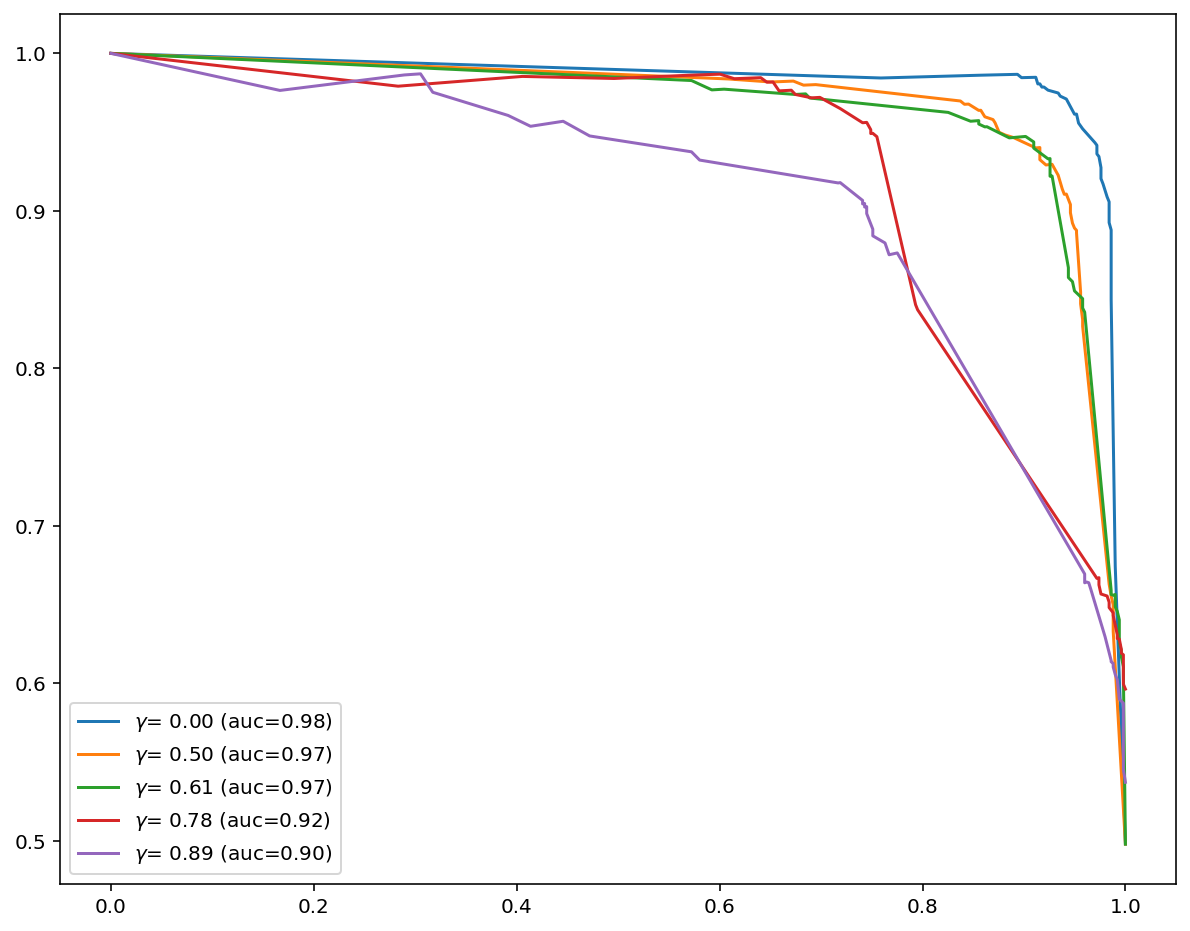

In [377]:
gammas = [0.0, 0.5, 0.6111111111111112, 0.7777777777777778, 0.8888888888888888]
plt.figure(figsize=(10,8))
for gamma in gammas:
    [precisons, recalls, thresholds] = precision_recall_curve(true_vals, probs[gamma])
    roc_auc = metrics.roc_auc_score(true_vals, probs[gamma])
    plt.plot(recalls, precisons, label=f"$\gamma$= {gamma:.2f} (auc={roc_auc:.2f})")
plt.legend();

In [364]:
# auc
from sklearn import metrics

In [370]:
gamma = 0.8888888888888888
metrics.roc_auc_score(true_vals, probs[gamma]) 


0.9034244547912766

In [359]:
size = sum(map(sum, st_nets[0.0][1].values()))
comp = {gamma: len(voting) for gamma, [merged, voting] in st_nets.items()}
    

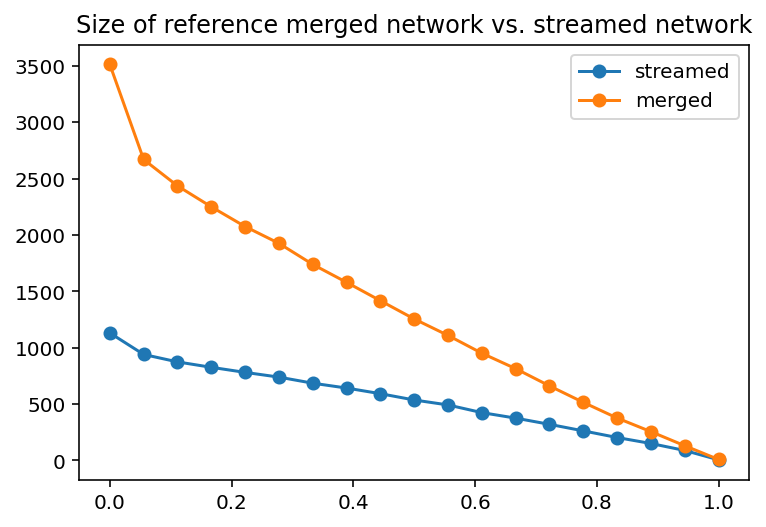

In [361]:
plt.title('Size of reference merged network vs. streamed network')
plt.plot(list(comp.keys()), list(comp.values()),'-o', label='streamed')
plt.plot(df.ref*d_size, '-o', label='merged')
plt.legend();

In [356]:
single_nets = dict()
for gamma in st_nets.keys():
    with open(f"../res/{gamma}-tc-singlevoting.pickle", 'rb') as f:
        nw = pickle.load(f)
        single_nets[gamma] = nw[gamma]

In [358]:
single_sizes = {g:len(a[0]) for g, a in single_nets.items()}

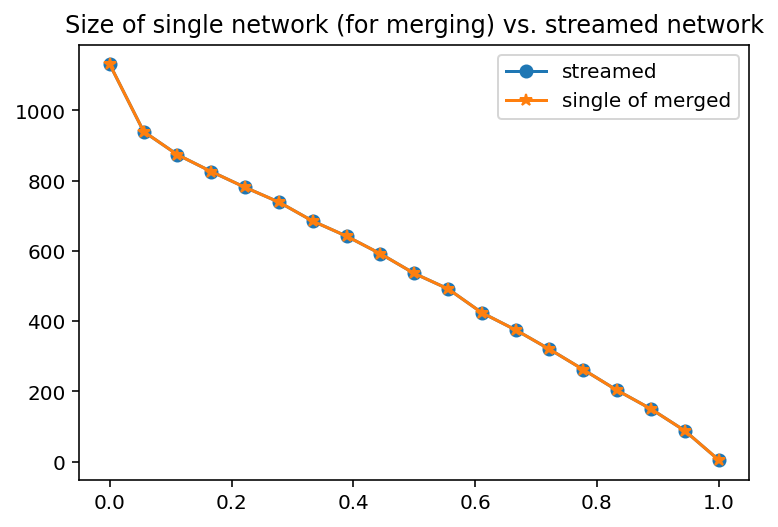

In [363]:
plt.title('Size of single network (for merging) vs. streamed network')
plt.plot(list(comp.keys()), list(comp.values()),'-o', label='streamed')
plt.plot(list(single_sizes.keys()), list(single_sizes.values()), '-*', label='single of merged')
plt.legend();

In [378]:
# Precision comprarision between streamed and merged

In [388]:
with open('../res/tc-new-mer.pickle', 'rb') as f:
    res_mer = pickle.load(f)

with open('../res/tc-stream-probs.pickle', 'rb') as f:
    res_str = pickle.load(f)

In [405]:
gammas = list(res_mer.keys())[:-1]
to_plot=dict()

for gamma in gammas:
    probs, true_vals = res_mer[gamma]
    [p1, r1, thresholds] = precision_recall_curve(true_vals, res_str[gamma])
    roc_auc1 = metrics.roc_auc_score(true_vals, probs) 
    
    [p2, r2, thresholds] = precision_recall_curve(true_vals, probs)
    roc_auc2 = metrics.roc_auc_score(true_vals, res_str[gamma])

    to_plot[gamma] = [p1, r1, roc_auc1, p2, r2, roc_auc2]

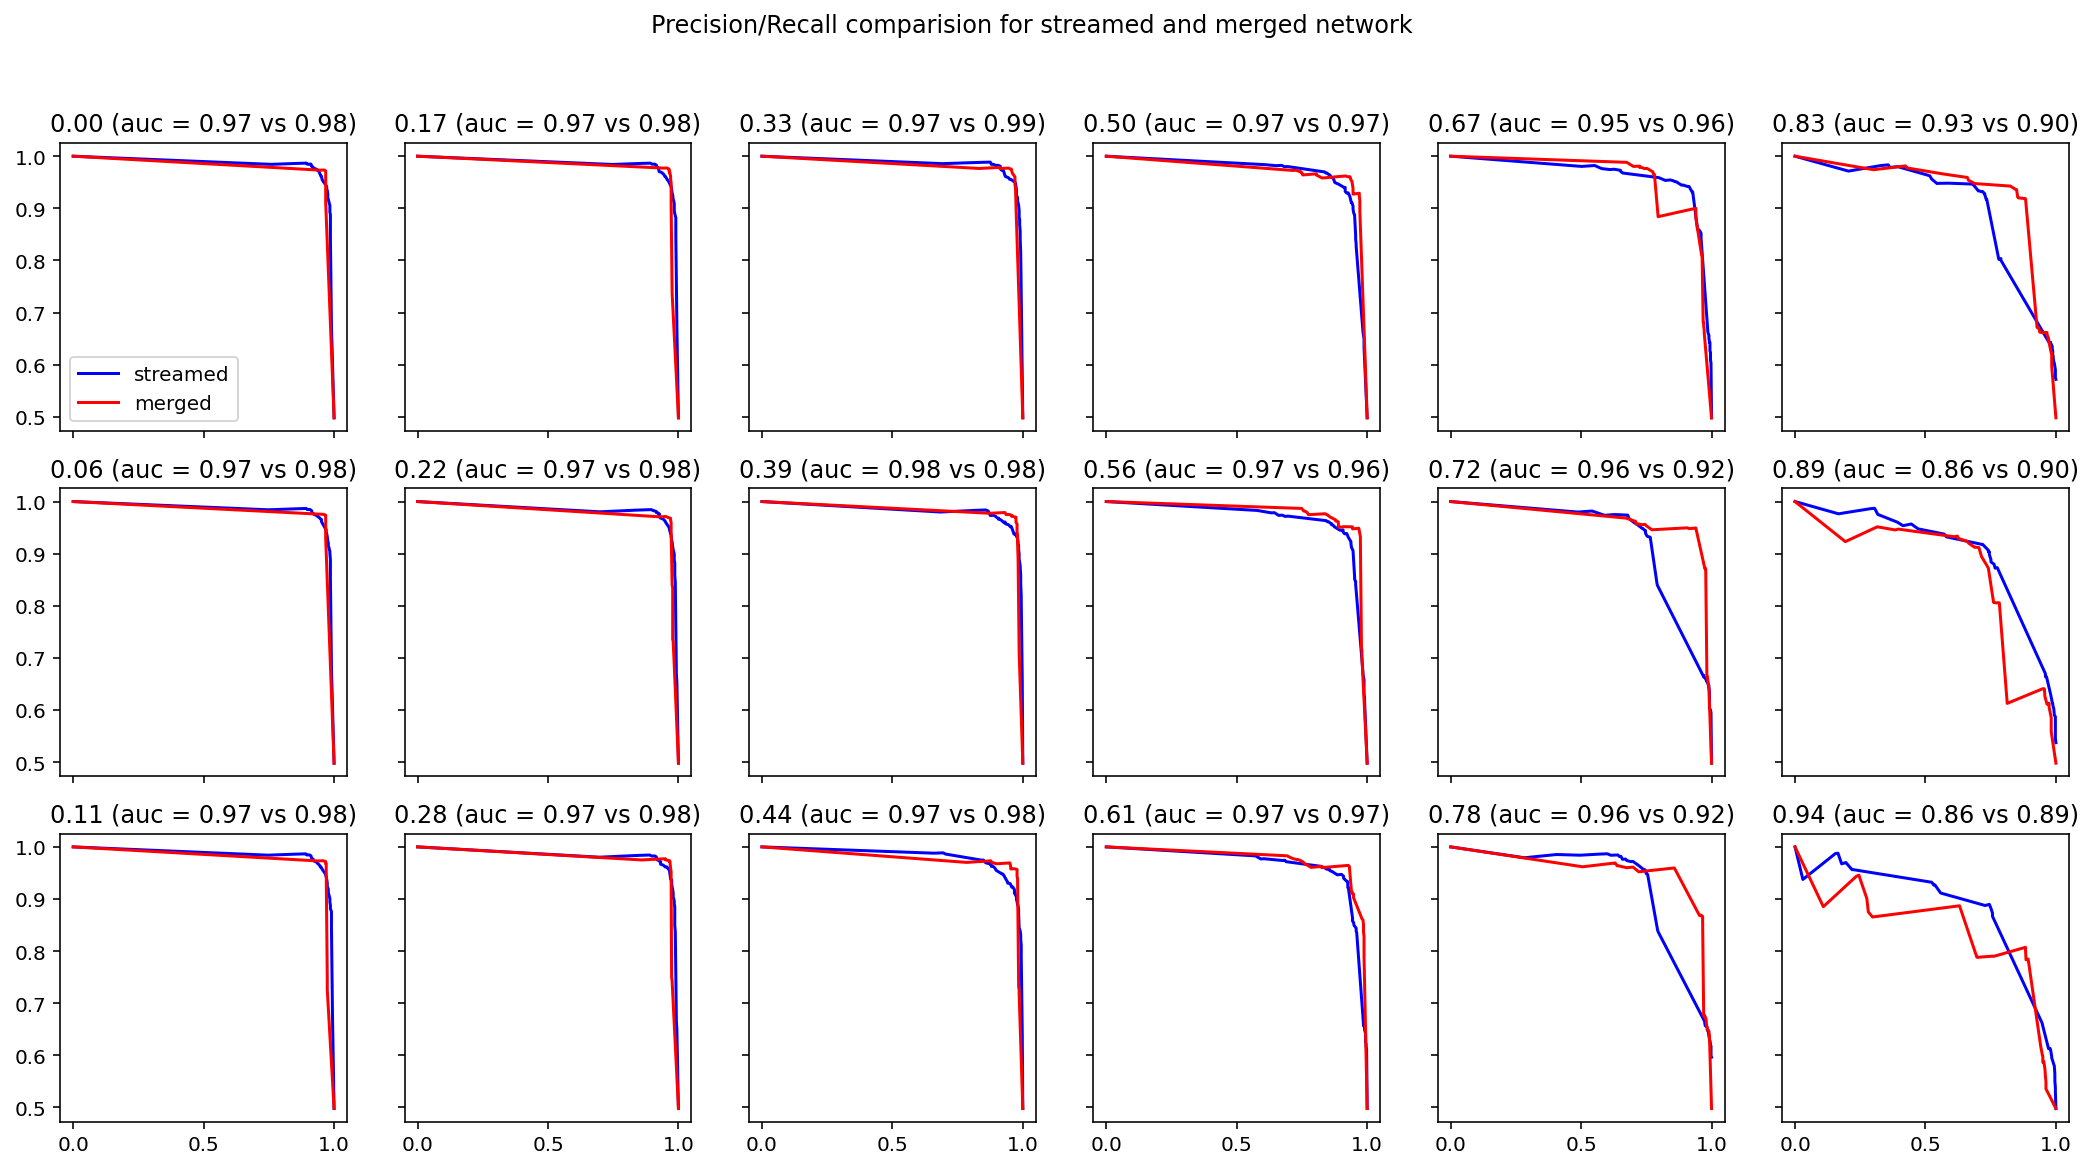

In [429]:
rows = 3
cols = 6

fig, axs = plt.subplots(rows, cols, figsize=(18, 9), sharex=True, sharey=True)
fig.suptitle('Precision/Recall comparision for streamed and merged network')
for i, gamma in enumerate(to_plot.keys()):
    [p1, r1, roc_auc1, p2, r2, roc_auc2] = to_plot[gamma]
    axs[i%rows, i//rows].plot(r1, p1, c='b', label='streamed')
    axs[i%rows, i//rows].plot(r2, p2, c='r', label='merged')
    axs[i%rows, i//rows].set_title(f"{gamma:.2f} (auc = {roc_auc1:.2f} vs {roc_auc2:.2f})")

axs[0,0].legend();

In [451]:
am = [1, 2, 5]

In [452]:
any(am)

True

In [453]:
any([])

False